<a href="https://colab.research.google.com/github/serereuk-tf/Tensorflow-Example/blob/main/Day1/TF_Data%26Augmentation_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day1 TF Data 설명 및 Augmentation 적용하는 방법
이전에 사용했던 예제를 다시 올려두고 시작합시다

In [1]:
#unzip the Files
!unzip -qq /content/train_tfrecord.zip

In [2]:
import glob
import numpy as np
from PIL import Image
import tensorflow as tf

# Tensorflow에서 알아서 최적화를 해주는 좋은 기능 #
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASSES = 100
IMAGE_SIZE = [32, 32]
AUG_BATCH = 12

In [3]:
def _onehot(image, label):
    """
    Label를 One-hot으로 만들어주는 방법 - CutMix, Mixup 등에 사용
    ex) '2' -> [0, 0, 1, 0, ....]
    """
    return image, tf.one_hot(label, CLASSES)


def _parse_function(serialized_item):
    """
    TF Records에 있는 내용물들을 압축해제 하는 방법
    이미지가 String으로 나오기 때문에 추가적으로 더 작업을 해줘야한다.
    tf.io.decode_png를 통해서 Stinrg -> Image Array
    Output:
        * Image : Tensor
        * Label : Tensor
    """
    parsed_ = tf.io.parse_example(
        serialized=serialized_item,
        features={
            "image": tf.io.FixedLenFeature([], dtype=tf.string),
            "label": tf.io.FixedLenFeature([], dtype=tf.int64)
        }
    )
    image = parsed_['image']
    image = tf.io.decode_png(image, channels=3)
    # 아래 코드는 이미지를 [0, 1]로 만들어주는 역할
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(parsed_['label'], tf.int32)
    return image, label

def draw(example, func=None):
    for (img,label) in example:
        img = img if func is None else func(img)
        plt.figure(figsize=(7,int(7*row/col)))
        for j in range(row*col):
            plt.subplot(row,col,j+1)
            plt.axis('off')
            plt.imshow(img[j,])
        plt.show()
        break

# TF Data 톺아보기
* batch
* zip
* shuffle
* prefetch
* cache
* interleave

## 1. batch

*   주어진 Dataset을 batch_size만큼 나눠주는 역할을 하는 친구

간단한 예제를 위해서 tf.data.Dataset.from_tensor_slices를 사용.  
이 친구 같은 경우는 리스트 혹은 어레이의 형태를 데이터 로더로 변경시켜주는 친구!


In [4]:
# Example
a = tf.range(10)
a = tf.data.Dataset.from_tensor_slices(a)
# 위 range 예제를 다음과 같이 표현 가능
# tf.data.Dataset.range(10)
a = a.batch(4)
for i in a:
    print(i)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


## 2. zip 

* Python의 zip과 같은 역할을 함

역시 간단한 예제를 통해서 확인해보자

a는 0 ~ 9, b는 9 ~ 0라고 할 때 두 데이터셋을 김밥처럼 잘라줌

In [5]:
a = np.arange(10)
b = list(range(9, -1, -1))
a = tf.data.Dataset.from_tensor_slices(a)
b = tf.data.Dataset.from_tensor_slices(b)
# 위 range 예제를 다음과 같이 표현 가능
# tf.data.Dataset.range(10)
train = tf.data.Dataset.zip((a, b)).batch(5)
for i in train:
    print('a : {}, b: {}'.format(i[0].numpy(), i[1].numpy()))

a : [0 1 2 3 4], b: [9 8 7 6 5]
a : [5 6 7 8 9], b: [4 3 2 1 0]


## 3. shuffle 

* 로더 안에 있는 데이터의 순서를 섞어줌

생각보다 오래 걸릴 수 있음!

seed 값은 다음과 같이 고정시킬 수 있음!

In [6]:
# 시드값을 고정시키면 다시 실행시켜도 내용이 같다
tf.random.set_seed(82)
a = tf.data.Dataset.range(10)
a = a.shuffle(10)
a = a.batch(4)
for i in a:
    print(i)

tf.Tensor([5 6 0 1], shape=(4,), dtype=int64)
tf.Tensor([4 8 9 2], shape=(4,), dtype=int64)
tf.Tensor([7 3], shape=(2,), dtype=int64)


In [7]:
# 다시 실행시킨 경우
tf.random.set_seed(82)
a = tf.data.Dataset.range(10)
a = a.shuffle(10)
a = a.batch(4)
for i in a:
    print(i)

tf.Tensor([5 6 0 1], shape=(4,), dtype=int64)
tf.Tensor([4 8 9 2], shape=(4,), dtype=int64)
tf.Tensor([7 3], shape=(2,), dtype=int64)


## 4, 5. Prefetch & Cache

* Prefetch란? - 공식 문서 참고

전처리와 훈련 스텝의 모델 실행을 오버랩  
t라는 시점에서 모델이 열심히 주어진 데이터로 훈련을 할 때 미리 t+1시점의 데이터를 불러오는 방법

* Cache란? - 공식 문서 참고

메모리 또는 로컬 저장소에 캐시 형태로 저장해서 다시 접근 할 때 빠르게 불러오는 방법.  
파일을 읽고 여는 과정들은 시간이 많이 걸리니까 캐시를 통해 미리 저장해두고 불러오는 방법을 추천.  


In [8]:
# Efficient Data Configuration
#https://www.kaggle.com/harveenchadha/effnetb4-tf-data-gpu-aug-5x-speedup-tta

def dataset_builder(ds, batch_size=64):
    ds = ds.cache('./dump.tfcache')
    ds = ds.shuffle(50000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


In [9]:
# TF Record 읽기
train_dataset = tf.data.TFRecordDataset(
    glob.glob('tfrecord_cifar100/train/tfr_*'))
# Parsing
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_dataset = dataset_builder(train_dataset, batch_size=12)

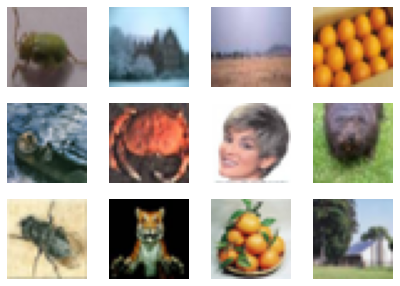

In [10]:
import matplotlib.pyplot as plt
row = 3; col = 4;
example = tf.data.Dataset.from_tensors( next(iter(train_dataset)) )
draw(example)

## 6. interleave

* 데이터 추출의 병렬화에 사용
* Block_length는 얼마나 읽을지에 관련된 파라메터

원격 저장소를 사용할 때는 IO가 부담이 더 클 수 있음

좋은 예제 

https://medium.com/@elynluo10/understanding-tf-data-dataset-interleave-c796627677dd

In [11]:
dataset = tf.data.Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
# NOTE: New lines indicate "block" boundaries.
dataset = dataset.interleave(
  lambda x: tf.data.Dataset.from_tensors(x).repeat(6),
    cycle_length=2, block_length=4)
list(dataset.as_numpy_iterator())[:10]

[1, 1, 1, 1, 2, 2, 2, 2, 1, 1]

# Image Augmentation을 적용하는 방법은 크게 3 가지

1. tf dataset에서 tf.image를 사용하여 변경하는 방법
    * 장점: Custom Augmentation을 적용하기 쉬움 함수로 만든 다음 map으로 씌우면 됨
    * 단점: 잘못 짜면 약간 Idle이 생길수도 있음. 
2. tf.keras.layers를 활용하는 방법
    * 장점: Sequential에 들어가기 때문에 굳이 Dataset을 수정 안해도 됨 모델 구조랑 연동 바로 가능, 가독성이 높음
    * 단점: Custom하게 만들기가 약간 어려움
3. ~~tf.Transform을 사용하는 방법~~ -> 새로운 Package로 이전함 TFX 참고
    * 장점: 실제로 모델을 서빙할 때 편리하다고 함
    * 단점: preprocessing_fn함수로 짜야하는데 예제가 별로 없음 ㅠㅠ

### 1. tf dataset 예제

In [12]:
# 1. Dataset을 활용한 방법

def Augmentation(image, label):
    """
    랜덤 Flip_LR를 적용한 모습 
    Output:
        * Image : Flipped Image
    """
    # 더 확실한 결과를 확인하기 위해 위아래로 뒤집음 
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_flip_left_right(image)
    return image, label


In [13]:
# TF Record 읽기
train_dataset = tf.data.TFRecordDataset(
    glob.glob('tfrecord_cifar100/train/tfr_*'))
# Parsing
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_dataset = dataset_builder(train_dataset, batch_size=12)
train_dataset = train_dataset.map(Augmentation, num_parallel_calls=AUTOTUNE)

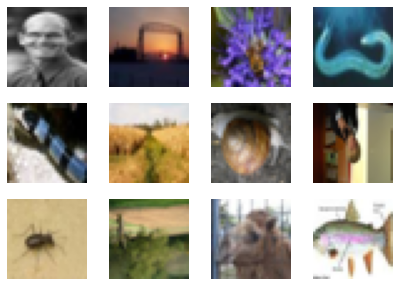

In [15]:
import matplotlib.pyplot as plt
row = 3; col = 4;
example2_Augmentation = tf.data.Dataset.from_tensors( next(iter(train_dataset)) )
draw(example2_Augmentation)

### 2. tf.keras.layers 사용

In [16]:
# 2. tf.keras.layer를 활용하는 방법

Augmentation2 = tf.keras.Sequential(
    [tf.keras.layers.experimental.preprocessing.RandomFlip('vertical')])


In [17]:
# TF Record 읽기
train_dataset = tf.data.TFRecordDataset(
    glob.glob('tfrecord_cifar100/train/tfr_*'))
# Parsing
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_dataset = dataset_builder(train_dataset, batch_size=12)

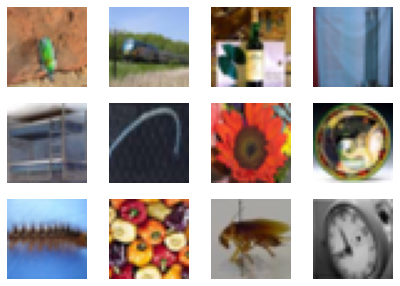

In [18]:
import matplotlib.pyplot as plt
row = 3; col = 4;
example3_Augmentation_layer = tf.data.Dataset.from_tensors( next(iter(train_dataset)) )
draw(example3_Augmentation_layer, Augmentation2)

In [19]:
# 3. Transform을 사용하는 방법
# import tfx
# preprocessing_fn 이라는 함수만 정의하면 됨

# 생략..!

# Custom한 Augmentation 만들기 - CutMix tf Dataset Example


출처 : https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu

In [20]:
def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [21]:
# TF Record 읽기
train_dataset = tf.data.TFRecordDataset(
    glob.glob('tfrecord_cifar100/train/tfr_*'))
# Parsing
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_dataset = dataset_builder(train_dataset, batch_size=12)
train_dataset = train_dataset.map(cutmix, num_parallel_calls=AUTOTUNE)

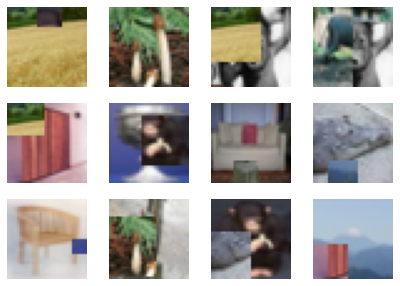

In [22]:
import matplotlib.pyplot as plt
row = 3; col = 4;
example4_CutMix = tf.data.Dataset.from_tensors( next(iter(train_dataset)) )
draw(example4_CutMix)

# Custom한 Augmentation 만들기 - CutMix tf.keras.Layer Example


In [26]:
from tensorflow.python.keras.engine.base_layer import Layer

class CutMix(Layer):
    """
    Cutmix를 적용하는 코드는 위와 일치 
    여기서 적용해줘야하는 부분은 call부분에 위 코드를 넣어주면 된다. 
    나머지 부분들은 shape를 확인하거나 config 파일을 받을 때를 위해서 만들어준 기능들
    """

    def __init__(self, PROBABILITY=1.0, name=None, **kwargs):
        self.prob = PROBABILITY
        self.dim = IMAGE_SIZE[0]
        super(CutMix, self).__init__(name=name, **kwargs)

    def call(self, image, label):
        imgs, labs = [], []
        for j in range(AUG_BATCH):
            # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
            P = tf.cast(tf.random.uniform([],0,1)<=self.prob, tf.int32)
            # CHOOSE RANDOM IMAGE TO CUTMIX WITH
            k = tf.cast(tf.random.uniform([],0,AUG_BATCH),tf.int32)
            # CHOOSE RANDOM LOCATION
            x = tf.cast(tf.random.uniform([],0,self.dim),tf.int32)
            y = tf.cast(tf.random.uniform([],0,self.dim),tf.int32)
            b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
            WIDTH = tf.cast( self.dim * tf.math.sqrt(1-b),tf.int32) * P
            ya = tf.math.maximum(0,y-WIDTH//2)
            yb = tf.math.minimum(self.dim,y+WIDTH//2)
            xa = tf.math.maximum(0,x-WIDTH//2)
            xb = tf.math.minimum(self.dim,x+WIDTH//2)
            # MAKE CUTMIX IMAGE
            one = image[j,ya:yb,0:xa,:]
            two = image[k,ya:yb,xa:xb,:]
            three = image[j,ya:yb,xb:self.dim,:]
            middle = tf.concat([one,two,three],axis=1)
            img = tf.concat([image[j,0:ya,:,:],middle,
                             image[j,yb:self.dim,:,:]],axis=0)
            imgs.append(img)
            # MAKE CUTMIX LABEL
            a = tf.cast(WIDTH*WIDTH/self.dim/self.dim,tf.float32)
            if len(label.shape)==1:
                lab1 = tf.one_hot(label[j],CLASSES)
                lab2 = tf.one_hot(label[k],CLASSES)
            else:
                lab1 = label[j,]
                lab2 = label[k,]
            labs.append((1-a)*lab1 + a*lab2)
                
        # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
        image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH, self.dim, self.dim,3))
        label2 = tf.reshape(tf.stack(labs),(AUG_BATCH, CLASSES))
        return image2,label2

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'PROBABILITY': self.prob
        }
        base_config = super(CutMix, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [27]:
# TF Record 읽기
train_dataset = tf.data.TFRecordDataset(
    glob.glob('tfrecord_cifar100/train/tfr_*'))
# Parsing
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_dataset = dataset_builder(train_dataset, batch_size=12)

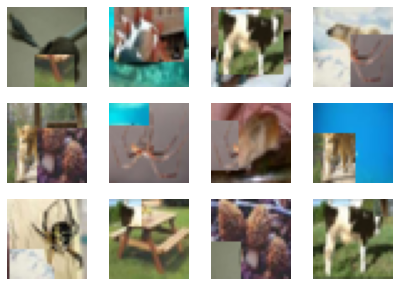

In [28]:
import matplotlib.pyplot as plt
row = 3; col = 4;
example5_CutMix_Layer = tf.data.Dataset.from_tensors( next(iter(train_dataset)) )
for (img,label) in example5_CutMix_Layer:
    img2, label2 = CutMix()(image=img, label=label)
    plt.figure(figsize=(7,int(7*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img2[j,])
    plt.show()
    break

# 다음 예제로 실제로 모델을 조금씩 만들어봅시다!